# EXPJ22 qPCR analysis


In [1]:
import numpy
import sys
sys.path.append("/Users/jdemaray/Dropbox (Gladstone)/Jack/Computational/instrument_scripts/")


from qPCR import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = "/Users/jdemaray/Dropbox (Gladstone)/Jack/Experiments/EXPJ22/"

GOI_list = ['ACTB', 'ACTB', 'CXCL10', 'CXCL10', 'CD19', 'CD19'] \
+ [None for i in range(18)]
cell_lines = {
        "A"	: "CL0021",
        "B"	: "CL0021",
        "C"	: "CL0022",
        "D"	: "CL0022",
        "E"	: "CL0023",
        "F"	: "CL0023",
        "G"	: "CL0024",
        "H"	: "CL0024",
        "I"	: "CL0025",
        "J"	: "CL0025",
        "K"	: "CL0026",
        "L"	: "CL0026",
        "M"	: "CL0027",
        "N"	: "CL0027",
        "O"	: "Transduction (-)",
        "P"	: "RT (-)"
    }

In [2]:
import string
ctdf = pd.read_csv(path+'20230816_EXPJ22_qPCR -  Quantification Cq Results.csv')
define_genes_cytokines(ctdf, GOI_list, cell_lines)
ct384 = get_ct_384(ctdf)

ct384.dropna()
empty_wells = [letter + "02" for letter in string.ascii_uppercase[:14]] + \
    [letter + "04" for letter in string.ascii_uppercase[:14]] + \
    [letter + "06" for letter in string.ascii_uppercase[:14]]
empty_wells
ct384.dropna(inplace=True)
ct384 = ct384[~ct384["Well"].isin(empty_wells)]
# ct384.to_excel(path+"Ct_values_annotated_2.xlsx")


# ∆∆Ct and fold change calculations
$$activation = \frac{fold change + efficiency - 1}{efficiency}\$$

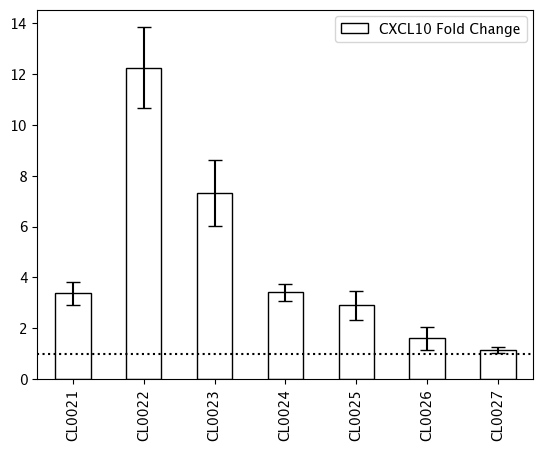

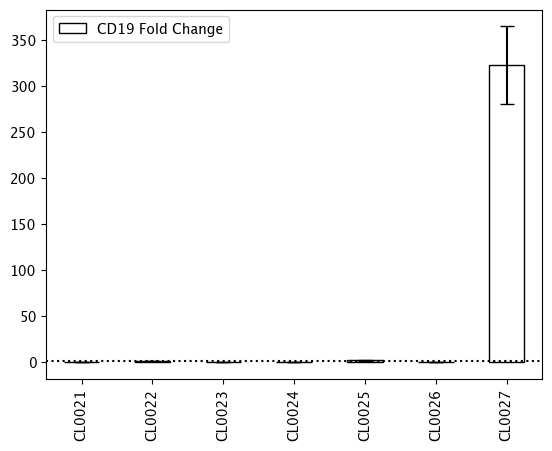

In [124]:
from uncertainties import ufloat

ct384.replace(0.0, 46.0, inplace=True)
ct_df = pd.DataFrame(columns=ct384.GOI.unique(), index=[i for i in ct384.Cytokine.unique() if i != "RT (-)"])
for index, row in ct_df.iterrows():
    for gene in ct_df.columns:
        Ct = ct384.loc[(ct384["GOI"]==gene) & (ct384["Cytokine"]==index), "Cq Mean"]
        ct_df.loc[index, gene] = ufloat(np.mean(Ct), np.std(Ct))
        # print(ct384.loc[(ct384["GOI"]==gene) & (ct384["Cytokine"]==index)])
ct_df.sort_index(inplace=True)
dct_df = pd.DataFrame(columns=[i for i in ct_df.columns if i != "ACTB"], index=ct_df.index)
for index, row in dct_df.iterrows():
    for gene in dct_df.columns:
        dCt = ct_df.loc[index, gene] - ct_df.loc[index, "ACTB"]
        dct_df.loc[index, gene] = dCt
ddct_df = pd.DataFrame(columns=dct_df.columns, index=[i for i in dct_df.index if i != "Transduction (-)"])
for index, row in ddct_df.iterrows():
    for gene in ddct_df.columns:
        ddCt = dct_df.loc[index, gene] - dct_df.loc["Transduction (-)", gene]
        ddct_df.loc[index, gene] = ddCt
fold_changes = ddct_df.apply((lambda x: 2**-x))
unpacked_column_names = [f"{i} Fold Change" for i in ddct_df.columns]+\
                       [f"{i} stdev" for i in ddct_df.columns]
unpacked_column_names.sort()
fc_plot = pd.DataFrame(columns=unpacked_column_names,
                       index=ddct_df.index)
fc_plot
# fc_plot.columns.sort_values()
for index, row in fc_plot.iterrows():
    for gene in fold_changes.columns:
        fc_plot.loc[index, f"{gene} Fold Change"]=fold_changes.loc[index, gene].nominal_value
        fc_plot.loc[index, f"{gene} stdev"]=float(fold_changes.loc[index, gene].std_dev)
# fold_changes.hist()
fc_plot.plot.bar(y="CXCL10 Fold Change", yerr="CXCL10 stdev", facecolor="none", edgecolor='k', capsize=5)
plt.axhline(y=1, c='k', linestyle=':')
fc_plot.plot.bar(y="CD19 Fold Change", yerr="CD19 stdev", facecolor="none", edgecolor='k', capsize=5)
plt.axhline(y=1, c='k', linestyle=':')
# plt.hist(x=fc_plot, bins=fc_plot.index)

In [150]:
fold_changes
efficiencies = pd.Series({"CL0021" : 0.168,
"CL0022" : 0.207,
"CL0023" : 0.175,
"CL0024" : 0.082,
"CL0025" : 0.099,
"CL0026" : 0.153,
"CL0027" : 0.109})
fold_changes["efficiency"] = efficiencies
fold_changes.dtypes
fold_changes["CXCL10_estimated_activation"] = (fold_changes["CXCL10"] + fold_changes["efficiency"] - 1) / fold_changes["efficiency"]
fold_changes

,CD19,CXCL10,efficiency,estimated_activation,CXCL10_estimated_activation
CL0021,0.10+/-0.35,3.4+/-0.4,0.168,5.952381,15.1+/-2.7
CL0022,1.2+/-0.4,12.3+/-1.6,0.207,4.830918,55+/-8
CL0023,0.03+/-0.10,7.3+/-1.3,0.175,5.714286,37+/-7
CL0024,0.05+/-0.17,3.42+/-0.33,0.082,12.195122,30+/-4
CL0025,2.0+/-0.4,2.9+/-0.6,0.099,10.101010,20+/-6
CL0026,0.05+/-0.18,1.6+/-0.5,0.153,6.535948,4.9+/-3.0
CL0027,(3.2+/-0.4)e+02,1.14+/-0.12,0.109,9.174312,2.3+/-1.1


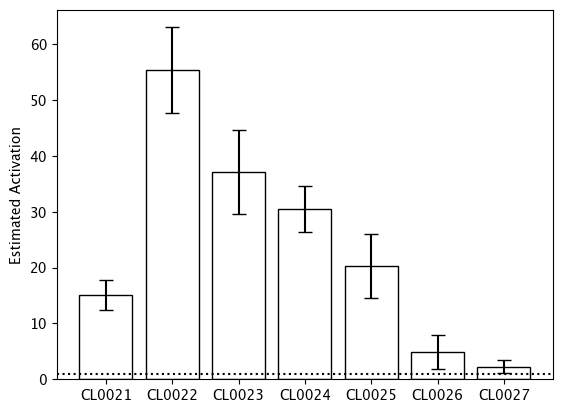

In [156]:
# Plotting estimated efficiencies
values = fold_changes["CXCL10_estimated_activation"].apply(lambda x: x.nominal_value)
stdevs = fold_changes["CXCL10_estimated_activation"].apply(lambda x: x.std_dev)
x = np.arange(len(values))
plt.bar(x, values, yerr=stdevs, capsize=5, facecolor='none', edgecolor='k', align='center')
plt.ylabel("Estimated Activation")
plt.xticks(x, fold_changes.index)
plt.axhline(y=1, c='k', linestyle=':')
plt.show()

# Melting curves

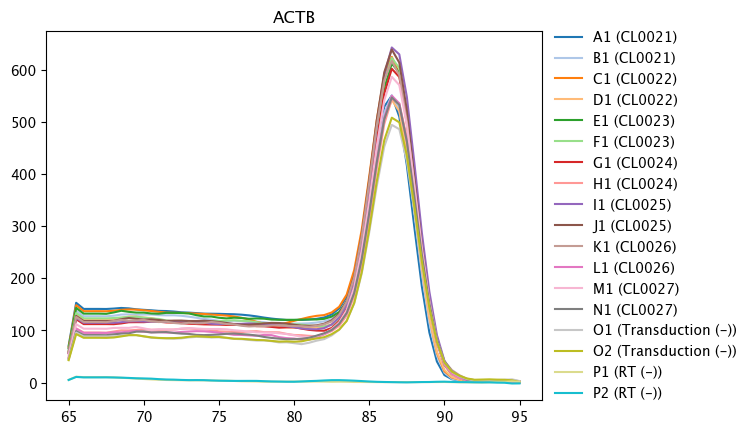

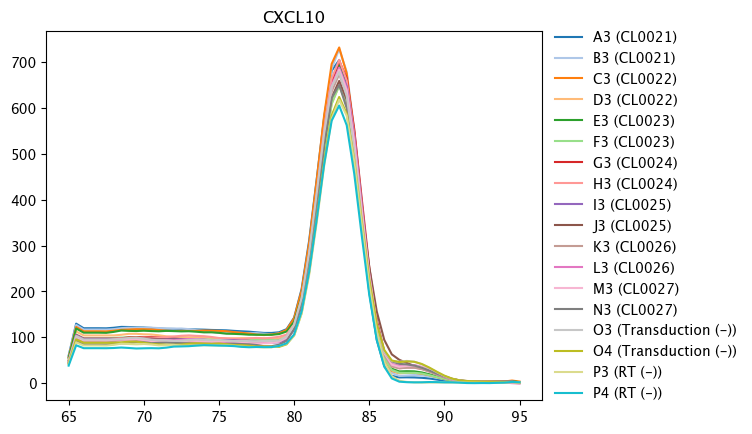

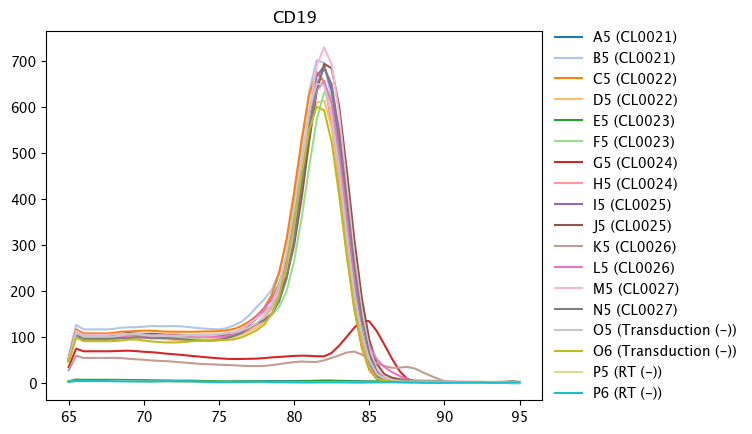

In [149]:
mcdf = process_mc_384(path+"20230816_EXPJ22_qPCR -  Melt Curve Derivative Results_SYBR.csv", GOI_list, cell_lines)

empty_wells_mc = [letter + "2" for letter in string.ascii_uppercase[:14]] + \
    [letter + "4" for letter in string.ascii_uppercase[:14]] + \
    [letter + "6" for letter in string.ascii_uppercase[:14]]

mcdf.dropna(inplace=True)
mcdf = mcdf[~mcdf["index"].isin(empty_wells_mc)]

for gene in pd.Series(GOI_list).unique():
    if gene is not None:
        plot_mc_384(mcdf, gene, cmap='tab20')
        # plot_mc_384(mcdf.loc[mcdf['index'].isin(['O2', 'O4', 'O6', 'P2', 'P4', 'P6'])], gene)